<a href="https://colab.research.google.com/github/scottvcaputo/Neural-Style-Transfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Setup**

> importing packages and modules



> Configuration




> selecting style and content images






In [ ]:
import os
import sys
import tensorflow as tf
tf.__version__

'2.2.0'

**IPython** is an alternative Python interpreter. It is an interactive shell used for computing in Python.

In [ ]:
import IPython.display as display

**Matplotlib** is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits



---



**matplotlib.pyplot** is a collection of command style functions that make matplotlib work like MATLAB. Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc. In matplotlib.pyplot various states are preserved across function calls, so that it keeps track of things like the current figure and plotting area, and the plotting functions are directed to the current axes (please note that "axes" here and in most places in the documentation refers to the axes part of a figure and not the strict mathematical term for more than one axis).



---


**Dynamic rc settings**
You can also dynamically change the default rc settings in a python script or interactively from the python shell. All of the rc settings are stored in a dictionary-like variable called matplotlib.rcParams, which is global to the matplotlib package. rcParams can be modified directly, as shown below. 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

%matplotlib inline

**NumPy** is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

In [ ]:
import numpy as np

**Pillow.Image** The Image module provides a class with the same name which is used to represent a PIL image. The module also provides a number of factory functions, including functions to load images from files, and to create new images.

Note: **Pillow** is a python imaging library

---
**Python time module** provides many ways of representing time in code, such as objects, numbers, and strings. It also provides functionality other than representing time, like waiting during code execution and measuring the efficiency of your code.

Note: this is an important module in time dimensionally based computations such as '*epochs*' 

---
**Functools** module provides tools for working with functions and other callable objects, to adapt or extend them for new purposes without completely rewriting them.



In [ ]:
import PIL.Image
import time
import functools

**SciPy** is a free and open-source Python library used for scientific computing and technical computing. SciPy builds on the NumPy array object and is part of the NumPy stack which includes tools like Matplotlib, pandas and SymPy, and an expanding set of scientific computing libraries.

In [ ]:
import scipy.io
import scipy.misc
import imageio

This section uses the PIL.Image module to convert information between a tensor and an image. 

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

This section is responsible for the content images and the style images.



'*tf.keras.utils.get_file*' is a command within tensorflow used to call files. This can be used to upload images from personal storage or from external locations. 



> tf.keras.utils.get_file(
    *fname*, *origin*, *untar*=False, *md5_hash*=None, *file_hash*=None,
    *cache_subdir*='datasets', *hash_algorithm*='auto', *extract*=False,
    *archive_format*='auto', *cache_dir*=None
)



> This will download a file from the url if not already stored in the cache








**Content Image & Style Image**

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


**Display the Images**

# **Visualization** 

This section defines functions neccessary to load the an image while setting limitations on the dimensions 


> The maximum dimension is 512 pixels here



tf.io.read_file(path_to_img)

    reads and outputs the entire contents of the input filename.

tf.image.decode_image()

    Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes string into a Tensor of type dtype.

tf.image.convert_image_dtype()

    Convert image to dtype, scaling its values if needed.

tf.cast()

    Casts a tensor to a new type.

long_dim & scale variables are responsible for controllong the size of the newly converted images




In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Here we define a simple function to display an image. 



> this allows us to display our images with a given title as shown below



In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Here we can call images through the newly created function '*imshow*'

plt.subplot 


    call signatures:

    subplot(nrows, ncols, index, **kwargs)

    subplot(pos, **kwargs)

    subplot(ax)



In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

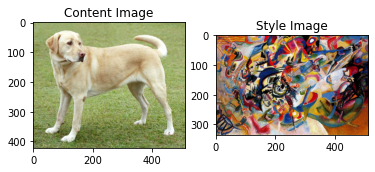

In [ ]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#Define Content and Representations 

The model runs through a numerical gradient of weights where the lower weights result in an image more similar to the content image and the higher weights result in an image more similar to the style image. 

This is because as the network progresses through deeper layers of the network using the given weights it carries more of an influence from one of the two. 

In addition to this variance, as the VGG19 network progresses deeper, the model identifies more and more complex features. 

The VGG19 network architecture consists of 19 layers dedicated to image classification. In order to take advantage of the network, the pre trained model is loaded and built on acting as a foundation. 

tf.keras.applications.vgg19.preprocess_input(

    x, data_format=None
)


---
keras.applications.vgg19.VGG19(

    include_top=True, weights='imagenet', input_tensor=None
  )


---


> include_top: whether to include the 3 fully-connected layers at the top of the network.

> weights: one of None (random initialization) or "imagenet" (pre-training on ImageNet).

> input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

In prediction probabilities we are controlling the input as the '*x*' we feed the model. 


---



.shape simply calls the shape to be shown in the output in order to understand what is being processed within the model. 

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 22s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

As shown above the VGG19 model was loaded with a head (include_top = True). When made False, there is no longer a "classification head" allowing us to build off of the model using the pre trained information (transfer learning). 

To effectively visualize this, we can observe the layers we are left with. 

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 2s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## **Intermediate layers for style and content**

Here, we are isolate these intermediate layers of the pretrained image classification network in order to define our style and content representations. Here, we feed the network our raw images where they are broken down pixel by pixel in order to extract computational information. 

This concept is what allows the convolutional neural network to generalize so well. Because vast networks like this have been trained across such a variety of images learning to recognize and understand both simple and complex features, it translates and transfers well into many other types of image classifications beyond exactly what the network is trained on. 

For this reason, and the idea that through the network, between the beginning and the end, the network learns this information, our raw images can be fed in and intermediate layer. In turn, the model can extract complex features from our images assessing them through complex computations in order to transfer the style and create and image. 


This allows us to disect the model, and choose intermediate layers from the network to represent the style and content of the image. 

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#Build the Model 

Here the function is defined in order to build a VGG model that reaturns a list of intermediate output values. 

This is why we will first load our model using the tf.keras.applications.VGG19() where the include_top = False. 


---
tf.keras.applications allows for easy extraction of the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

    model = Model(inputs, outputs)


In [ ]:
def vgg_layers(layer_names):
  
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

###Create the model 

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



# Calculate Style

The style of an image can be described using the correlations across the various feature maps. 

In order to calculate a Gram matrix that includes this information, take the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for specific layers.

This can be implemented concisely using the tf.linalg.einsum 

---


tf.einsum(

    equation, *inputs, **kwargs
)

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Extract Style and Content

Here, we will tell the model begin actually computing what the numerical information it has extracted from our raw images actually mean and represent in order to create our own newly styled image. 

This is done building a model that retunrs the style and content tensors. 


---
Here we use the newly defined gram_martix function output the images in a computationally understandable form for the network. 


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

Using the newly created class, we call our style layer and content layer as the parameters.

We then carry out extraction on a constant. These are simply building off of the class we built (StyleContentModel).

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

Data visualization of the style and content images. 

In [ ]:
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228444
    max:  28014.557
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.473
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.3
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320504.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


#Run Gradient Descent 

Using the style and content extractor, the style transfer algorithm can now be properly implemented. 

To do this, calculate the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set style and content target values

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Given that we are running gradient descent, we must define a variable for the algorithm to optimize. We will define a tf.Variable() containing our image for optimization. 

The content_image will help speed up initializion. 


---
Note: the tf.Variable() must be the same shape as the content image


In [ ]:
image = tf.Variable(content_image)

Given this is a float image, a function can be defined to normalize the values (contain in a range of [0, 1]).

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer

There are multiple possible optimizers to be run here such as:


> LBFGS



> Adam 

In the ducmentation this was originally published in, LBFGS was used but Adam can also be used here. 


---
Tensorflow 2:

tf.compat.v1.keras.optimizers



###Optimizers:
**class Adadelta:** Optimizer that implements the Adadelta algorithm.

**class Adagrad:** Optimizer that implements the Adagrad algorithm.

**class Adam:** Optimizer that implements the Adam algorithm.

**class Adamax:** Optimizer that implements the Adamax algorithm.

**class Ftrl:** Optimizer that implements the FTRL algorithm.

**class Nadam:** Optimizer that implements the NAdam algorithm.

**class Optimizer:** Updated base class for optimizers.

**class RMSprop:** Optimizer that implements the RMSprop algorithm.

**class SGD:** Stochastic gradient descent and momentum optimizer.

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Optimization
style_weight=1e-2
content_weight=1e4

Computing the "Loss Function"

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

tf.GradientTape is used to update the image


---
This is used differently in Tensorflow 2


In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Test steps

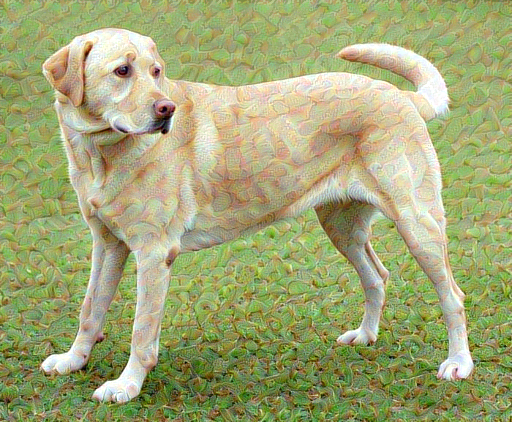

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

This image proves to us the model is working, but tells us the network is not being fully optimized. 

Perform a longer optimization in order for the network to more heavily integrate the data extracted from the style image. 

The section belows relies on the imported *time* python module (imported in intilization). 

Clarification:



> An epoch consists of one full cycle through the training data.



> Iteration is another name to indicate training step

> The loss provides insight on whether or not the model is performing as predicted. Ideally the loss decreases over time, and can spike from noise in batch gradient descent. 



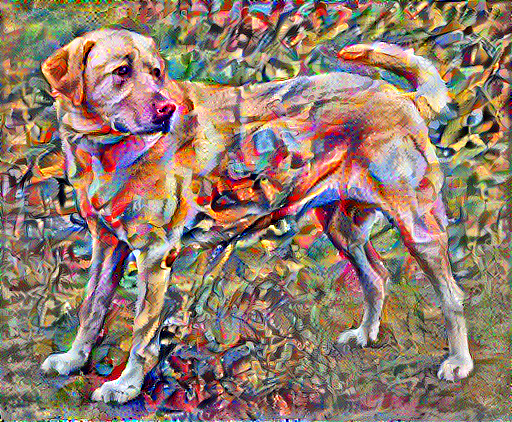

Train step: 1000
Total time: 201.4


In [ ]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

# Total Variation Loss

total variation loss is implemented to act as an explicit regularization term. This is necessary because this standardized gradient descent produces high frequency reults. 

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

The high frequenc compenent essentially acts as an edge detector. 

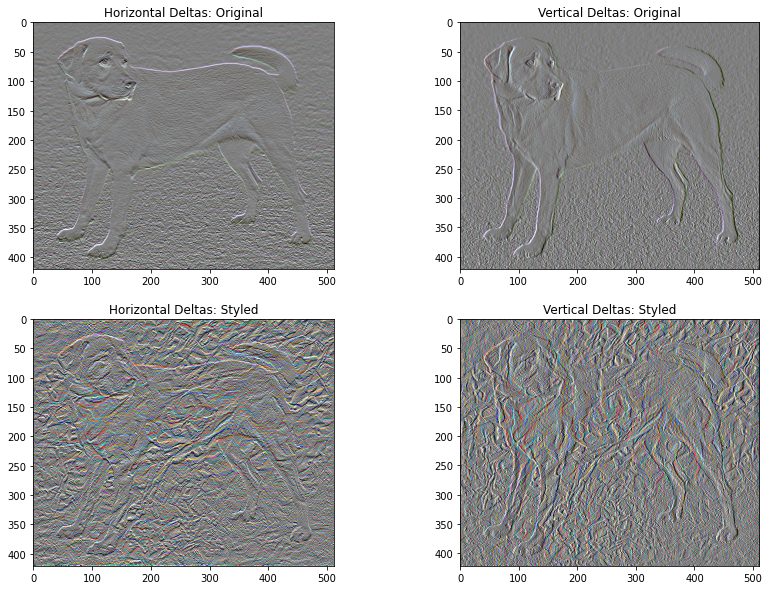

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

The regularization loss associated with this is the sum of the squares of the values

These functions below are slightly different in Tensorflow 2


---
tf.math.reduce_sum(

    input_tensor,
    axis=None,
    keepdims=None,
    name=None,
    reduction_indices=None,
    keep_dims=None
)

- Computes the sum of elements across dimensions of a tensor

---
tf.math.abs(

    x,
    name=None
)
- Computes absolute value of a tensor 



In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

149368.67

This demonstrates what must be computed in order to carry this out, below is a standardized implementation. 


---
tf.image.total_variation(
  
    images,
    name=None
)


In [ ]:
tf.image.total_variation(image).numpy()

array([149368.67], dtype=float32)

# Re-run Optimization

This time, we include the train_step function and set a total variation weight

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable just as before 

In [ ]:
image = tf.Variable(content_image)

Run the optimization

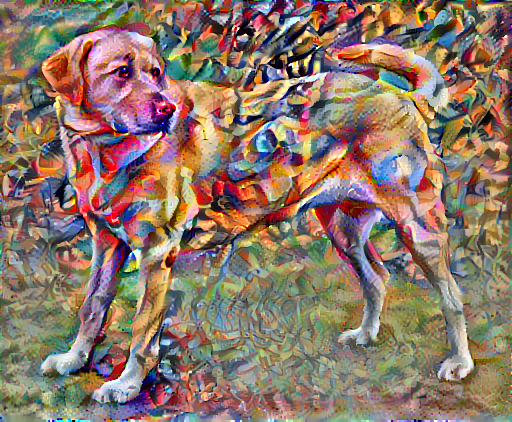

Train step: 1000
Total time: 203.7


In [ ]:
import time
# this starts the time using the time() function in the time module 
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    # epoch progression
    step += 1
    # what the train_step function is acting on
    train_step(image)
    print(".", end='')

  # Displays information to better understand whats taking place   
  # In order to stop on the last epoch (show the image rather than clear it)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  # shows epoch step as it progresses (updates because it is in the for loop)
  print("Train step: {}".format(step))

end = time.time()
# using the time module shows how long the model took 
# external to the loop as this should only be recored once and the stop
print("Total time: {:.1f}".format(end-start))

Save results 

In [ ]:
file_name = 'stylized-image-exdog.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>